In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import Helper_FCN as HFCN #Cuaderno con funciones de ayuda

import tensorflow as tf
import scipy.io

from keras import layers
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential, Model, load_model
from keras.utils import Sequence, plot_model
from keras.losses import Loss

from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

%load_ext tensorboard

In [ ]:
batch_size = 64 #NO CAMBIAR YA QUE OPTIMIZA LA MAXIMA RAM POSIBLE

main_dir = 'C:/V2U/Global_FCN/Global_FCN/'
total_data = 2627987

train_data = int(np.round((25600*2)/batch_size))

print("Cada epoch ve " + str(train_data) + " batches de datos en entrenamiento, en total " + str(train_data*batch_size) + " datos y un " + str(np.round(train_data*batch_size/total_data,2)) + " porciento del total")

Cada epoch ve 800 batches de datos en entrenamiento, en total 51200 datos y un 0.02 porciento del total


In [ ]:
separated_orbits = True

mean_extension = 2000
epochs = 500

def process_data(test=False):
    xVectors_batch = []
    Ics_batch = []
    Us_batch = []

    loop_range = range(batch_size) if not test else range(1000) #Para hacer las predicciones de la red, 1000 ya que es la resolucion del output de la red

    for _ in loop_range:   

        if test == False:
            random_file = random.randint(1, total_data-1)
        else:
            if _ == 0:
                random_file = random.randint(1, total_data-1)

        file_route = main_dir + str(random_file) + '.mat'
        data = scipy.io.loadmat(file_route)
        
        xVectors, Us, Ic = HFCN.Extended_Function_Dataset(data, mean_extension, test, _, separated_orbits)

        xVectors_batch.append(xVectors)
        Ics_batch.append(Ic)
        Us_batch.append(Us)

    xVectors_batch = np.array(xVectors_batch)
    Ics_batch = np.array(Ics_batch)
    Us_batch = np.array(Us_batch)

    #Normalizacion del batch
    #xVectors_batch =  (xVectors_batch - np.min(xVectors_batch)) / (np.max(xVectors_batch) - np.min(xVectors_batch))
    Ics_batch = Ics_batch/1000
    #Us_batch = (Us_batch - np.min(Us_batch)) / (np.max(Us_batch) - np.min(Us_batch))

    return [np.array(xVectors_batch), np.array(Ics_batch)], [np.array(Us_batch)]

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, data, batch_size, test=False):
        self.data = data
        results = Parallel(n_jobs=-1)(delayed(process_data)(test=False) for _ in range(self.data))
        self.x = np.concatenate([result[0][0] for result in results])
        self.Ics = np.concatenate([result[0][1] for result in results])
        self.y = np.concatenate([result[1][0] for result in results])
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_Ics = self.Ics[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return [np.array(batch_x), np.array(batch_Ics)], [np.array(batch_y)]

    def on_epoch_end(self):
        del self.x, self.y
        results = Parallel(n_jobs=-1)(delayed(process_data)(test=False) for _ in range(self.data))
        self.x = np.concatenate([result[0][0] for result in results])
        self.Ics = np.concatenate([result[0][1] for result in results])
        self.y = np.concatenate([result[1][0] for result in results])

train_set = CustomDataGenerator(train_data, batch_size, test=False)

In [ ]:
# Define the MirroredStrategy in case there are multiple GPUs available 
# https://www.tensorflow.org/guide/distributed_training

# strategy = tf.distribute.MirroredStrategy(devices=["/GPU:0", "/GPU:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#with strategy.scope():

input_1 = layers.Input(shape=(mean_extension, 2), name='input_1')
input_2 = layers.Input(shape=(1,), name='input_2')
repeated_input_2 = layers.RepeatVector(mean_extension)(input_2) # Repeat the input_2 tensor to match the shape of input_1

x_input = layers.concatenate([input_1, repeated_input_2], axis=-1)

# Block 1 Attention block

x = layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.05)(x_input, x_input)
res = layers.Add()([x, x_input])

x = layers.Conv1D(filters=1024, kernel_size=1, activation="relu")(res)
x = layers.Conv1D(filters=x_input.shape[-1], kernel_size=1)(x)
xn = layers.Add()([x, res])

#Block 2 Attention block
  
x = layers.MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.05)(xn, xn)
res = layers.Add()([x, xn])

x = layers.Conv1D(filters=1024, kernel_size=1, activation="relu")(res)
x = layers.Conv1D(filters=x_input.shape[-1], kernel_size=1)(x)
xn = layers.Add()([x, res])

#Block 3 Conv Block

x = layers.Conv1D(filters=512, kernel_size=7, activation="relu")(xn)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.2)(x)

#Block 4  Global Max and Average Pooling

x_max = layers.GlobalMaxPooling1D()(x)
x_avg = layers.GlobalAveragePooling1D()(x)
x = layers.concatenate([x_max, x_avg]) 

# Block 5 Output Block

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='linear', name='output')(x)

# Define the model
model = Model(inputs=[input_1, input_2], outputs=x, name=str(mean_extension) + '_input_model')

loss = 'mse'
metrics = 'mse'

learning_rate = 0.00015
final_lr = 0.000030

warmup_epochs = 6
decay_factor =  final_lr/learning_rate
lr_schedule = LearningRateScheduler(lambda epoch, lr: HFCN.lr_warmup_scheduler(epoch, lr, learning_rate, warmup_epochs, epochs, decay_factor))

optimizer = Adam(learning_rate=learning_rate)
    
model.compile(optimizer=optimizer, loss=HFCN.AsymmetricMSELoss(underestimation_weight=10), metrics=metrics)

model.architecture = str(HFCN.model_details(model, learning_rate, batch_size, loss))
model.summary()

Model: "2000_3000_randlength_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2000, 2)]    0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 2000, 1)      0           ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 2000, 3)      0           ['input_1[0][0]',                
                                                                  'repeat_vec

In [ ]:
print("The model trains with " + str(epochs*train_data*batch_size) + " from the " + str(total_data) + " total, that being " + str(np.round(100*epochs*train_data*batch_size/total_data, 2)) + "% of the dataset")'

checkpoint_path = ''
tensorboard_log_path = ''

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True) # Checkpoint route to be defined
tensorboard = TensorBoard(log_dir = tensorboard_log_path, histogram_freq=1, write_graph=False, write_images=False) # Log dir to be defined
#early_stop = EarlyStopping('loss', patience=100, verbose=1)
terminate = TerminateOnNaN()
#reduce_LR_stagnate = ReduceLROnPlateau(monitor='mse', factor=0.8, patience=100, min_lr=0.0001)

callbacks = [tensorboard, model_checkpoint, terminate, lr_schedule]

La red entrena con 25600000 datos de los 2627987 toales, es decir un 974.13% de los datos


In [ ]:
history = model.fit(train_set, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    steps_per_epoch = train_data,
                    callbacks=callbacks)
        
model.save(checkpoint_path+'_modellast.h5')
np.save(checkpoint_path+'_history1.npy',history.history) 

Epoch 123/500
800/800 [==============================] - ETA: 0s - loss: 6.6183e-04 - mse: 4.4129e-04
Epoch 123: loss improved from inf to 0.00066, saving model to results/1D_IC_2_U/2000/2000_3000_randlength_2/epochs_500_batch_size_64/checkpoints\2000_3000_randlength_2.hdf5
800/800 [==============================] - 343s 415ms/step - loss: 6.6183e-04 - mse: 4.4129e-04 - lr: 1.0246e-04
Epoch 124/500
800/800 [==============================] - ETA: 0s - loss: 6.8239e-04 - mse: 4.5608e-04
Epoch 124: loss did not improve from 0.00066
800/800 [==============================] - 331s 413ms/step - loss: 6.8239e-04 - mse: 4.5608e-04 - lr: 1.0212e-04
Epoch 125/500
800/800 [==============================] - ETA: 0s - loss: 6.7324e-04 - mse: 4.4844e-04
Epoch 125: loss did not improve from 0.00066
800/800 [==============================] - 333s 416ms/step - loss: 6.7324e-04 - mse: 4.4844e-04 - lr: 1.0179e-04
Epoch 126/500
800/800 [==============================] - ETA: 0s - loss: 6.7921e-04 - mse: 4

32/32 [==============================] - 1s 16ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


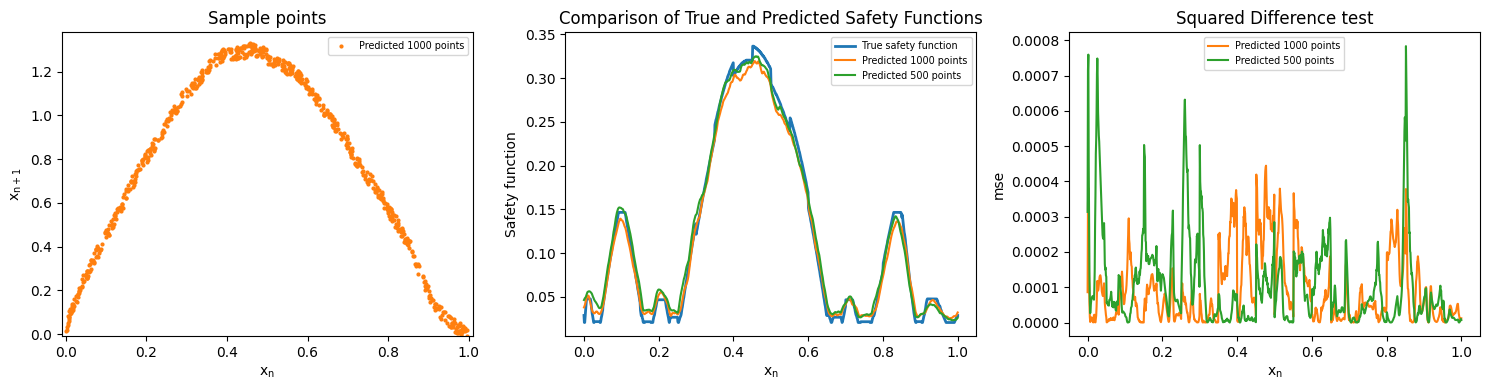

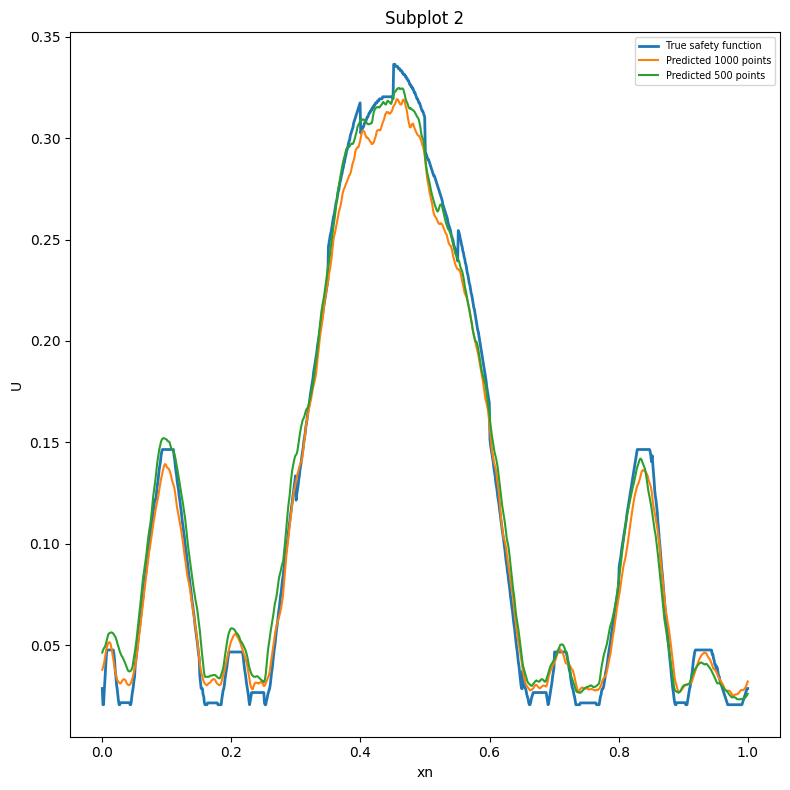

In [ ]:
test_set = process_data(test=True)
xVectors = test_set[0][0]
ICs = test_set[0][1]
Us = test_set[1][0]

print(xVectors.shape, ICs.shape, Us.shape)

test_pred = model.predict([xVectors, ICs])

# Adjusting plot settings for better appearance
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# First subplot (ax1)

ax1.plot(xVectors[0, :, 0], xVectors[0, :, 1], '.', markersize=4,  label='Sampled points')
ax1.axis([-0.01, 1.01, -0.01, 1 + (np.max(xVectors) - 0.95)])
ax1.set_title('Sample points', fontsize=12)
ax1.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
ax1.set_ylabel('$\mathrm{x_{n+1}}$', fontsize=10)
ax1.legend(loc='best', fontsize='x-small')
#ax1.grid(True)

# Second subplot (ax2)
ax2.plot(np.linspace(0, 1, 1000), Us, label='True safety function', linewidth=2)
ax2.plot(np.linspace(0, 1, 1000), test_pred, label='Predicted function', color='red', linewidth=1.5)

ax2.set_title('Comparison of True and Predicted Safety Functions', fontsize=12)
ax2.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
ax2.set_ylabel('Safety function', fontsize=10)
ax2.legend(loc='best', fontsize='x-small')

# Third subplot (ax3)
for i in range(len(test_pred)):
    ax3.plot(np.linspace(0, 1, 1000), (Us - test_pred.reshape(-1)) ** 2, label='Squared Difference of each point with its prediction', linewidth=1.5)

ax3.set_title('Squared Difference test', fontsize=12)
ax3.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
ax3.set_ylabel('mse', fontsize=10)
ax3.legend(loc='best', fontsize='x-small')

# Adjust the layout to ensure no overlap
plt.tight_layout()
plt.show()

# Optional: Adjust another figure if needed
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, 1000), Us, label='True safety function', linewidth=2)
plt.plot(np.linspace(0, 1, 1000), test_pred, label='Predicted function', color='red', linewidth=1.5)

plt.title('Comparison of True and Predicted Safety Functions', fontsize=12)
plt.set_xlabel('$\mathrm{x_{n}}$', fontsize=10)
plt.set_ylabel('Safety function', fontsize=10)
plt.legend(loc='best', fontsize='x-small')

# Show the figure
plt.tight_layout()
plt.show()